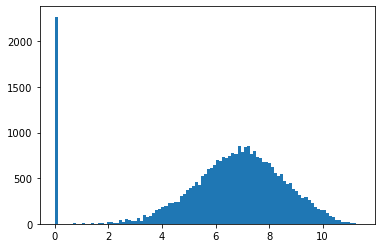

In [33]:
plt.hist(y_train, bins=100);

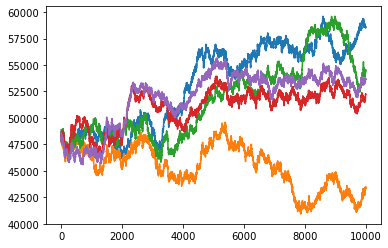

In [16]:
for x in range(5):
    plt.plot(hg_fully_partial_results['poten_model'][x][0]);

In [1]:
%run data_setup

In [2]:
import numpyro
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive, HMC
import numpyro.distributions as dist
from sklearn.preprocessing import LabelEncoder
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoIAFNormal
from numpyro.handlers import reparam
from numpyro.optim import Adam
import jax.numpy as jnp
from jax import random
import statsmodels.api as sm
from numpyro.infer.reparam import LocScaleReparam
from numpyro.diagnostics import hpdi

numpyro.enable_x64()
prng_seed = random.PRNGKey(0)
assert numpyro.__version__.startswith("0.13.2")

# Hierarchical Models

In [3]:
# global control variables
learning_rate = 1e-2
vi_iters = 10000

num_warmup = 250
num_samples = 100
num_chains = 1
thinning = 1
target_accept_prob = 0.99
max_tree_depth = 12

In [4]:
def hg_intercept_partial(pool_code, logX_ijt, hyperparameters, logM_ijt=None):
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(10.0))

    μ_α = numpyro.sample("μ_α", dist.Normal(hyperparameters['Β_param'][0], np.sqrt(np.diag(hyperparameters['cov_Β'])[0])))
    β_1 = numpyro.sample("β_1", dist.Normal(hyperparameters['Β_param'][1], np.sqrt(np.diag(hyperparameters['cov_Β'])[1])))
    β_2 = numpyro.sample("β_2", dist.Normal(hyperparameters['Β_param'][2], np.sqrt(np.diag(hyperparameters['cov_Β'])[2])))
    β_3 = numpyro.sample("β_3", dist.Normal(hyperparameters['Β_param'][3], np.sqrt(np.diag(hyperparameters['cov_Β'])[3])))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(np.sqrt(np.pi/2) * hyperparameters['σ_param']))

    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        σ = numpyro.sample("σ", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    μ_ijt = α[pool_code] + β_1 * logX_ijt[:,0] + β_2 * logX_ijt[:,1] + β_3 * logX_ijt[:,2]
    σ_ij = σ[pool_code]

    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("logM_ijt", dist.TruncatedNormal(μ_ijt, σ_ij, low=0), obs=logM_ijt)

In [5]:
def hg_fully_partial(pool_code, logX_ijt, hyperparameters, logM_ijt=None):
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(10))
    σ_β_1 = numpyro.sample("σ_β_1", dist.HalfNormal(10))
    σ_β_2 = numpyro.sample("σ_β_2", dist.HalfNormal(10))

    μ_α = numpyro.sample("μ_α", dist.Normal(hyperparameters['Β_param'][0], np.sqrt(np.diag(hyperparameters['cov_Β'])[0])))
    μ_β_1 = numpyro.sample("μ_β_1", dist.Normal(hyperparameters['Β_param'][1], np.sqrt(np.diag(hyperparameters['cov_Β'])[1])))
    μ_β_2 = numpyro.sample("μ_β_2", dist.Normal(hyperparameters['Β_param'][2], np.sqrt(np.diag(hyperparameters['cov_Β'])[2])))
    β_3 = numpyro.sample("β_3", dist.Normal(hyperparameters['Β_param'][3], np.sqrt(np.diag(hyperparameters['cov_Β'])[3])))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(np.sqrt(np.pi/2) * hyperparameters['σ_param']))

    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β_1 = numpyro.sample("β_1", dist.Normal(μ_β_1, σ_β_1))
        β_2 = numpyro.sample("β_2", dist.Normal(μ_β_2, σ_β_2))
        σ = numpyro.sample("σ", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    μ_ijt = α[pool_code] + β_1[pool_code] * logX_ijt[:,0] + β_2[pool_code] * logX_ijt[:,1] + β_3 * logX_ijt[:,2]
    σ_ij = σ[pool_code]
    
    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("logM_ijt", dist.TruncatedNormal(μ_ijt, σ_ij, low=0), obs=logM_ijt)

In [6]:
def hr_intercept_partial(pool_code, logX_ijt, hyperparameters, logM_ijt=None):
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(10))

    μ_α = numpyro.sample("μ_α", dist.Normal(hyperparameters['Β_param'][0], np.sqrt(np.diag(hyperparameters['cov_Β'])[0])))
    β_1 = numpyro.sample("β_1", dist.Normal(hyperparameters['Β_param'][1], np.sqrt(np.diag(hyperparameters['cov_Β'])[1])))
    β_2 = numpyro.sample("β_2", dist.Normal(hyperparameters['Β_param'][2], np.sqrt(np.diag(hyperparameters['cov_Β'])[2])))
    β_3 = numpyro.sample("β_3", dist.Normal(hyperparameters['Β_param'][3], np.sqrt(np.diag(hyperparameters['cov_Β'])[3])))
    β_4 = numpyro.sample("β_4", dist.Normal(hyperparameters['Β_param'][4], np.sqrt(np.diag(hyperparameters['cov_Β'])[4])))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(np.sqrt(np.pi/2) * hyperparameters['σ_param']))

    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        σ = numpyro.sample("σ", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    μ_ijt = α[pool_code] + β_1 * logX_ijt[:,0] + β_2 * logX_ijt[:,1] + β_3 * logX_ijt[:,2] + β_4 * logX_ijt[:,3]
    σ_ij = σ[pool_code]

    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("logM_ijt", dist.TruncatedNormal(μ_ijt, σ_ij, low=0), obs=logM_ijt)

In [7]:
def hr_fully_partial(pool_code, logX_ijt, hyperparameters, logM_ijt=None):
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(10))
    σ_β_1 = numpyro.sample("σ_β_1", dist.HalfNormal(10))
    σ_β_2 = numpyro.sample("σ_β_2", dist.HalfNormal(10))
    σ_β_3 = numpyro.sample("σ_β_3", dist.HalfNormal(10))
    σ_β_4 = numpyro.sample("σ_β_4", dist.HalfNormal(10))

    μ_α = numpyro.sample("μ_α", dist.Normal(hyperparameters['Β_param'][0], np.sqrt(np.diag(hyperparameters['cov_Β'])[0])))
    μ_β_1 = numpyro.sample("μ_β_1", dist.Normal(hyperparameters['Β_param'][1], np.sqrt(np.diag(hyperparameters['cov_Β'])[1])))
    μ_β_2 = numpyro.sample("μ_β_2", dist.Normal(hyperparameters['Β_param'][2], np.sqrt(np.diag(hyperparameters['cov_Β'])[2])))
    μ_β_3 = numpyro.sample("μ_β_3", dist.Normal(hyperparameters['Β_param'][3], np.sqrt(np.diag(hyperparameters['cov_Β'])[3])))
    μ_β_4 = numpyro.sample("μ_β_4", dist.Normal(hyperparameters['Β_param'][4], np.sqrt(np.diag(hyperparameters['cov_Β'])[4])))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(np.sqrt(np.pi/2) * hyperparameters['σ_param']))

    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β_1 = numpyro.sample("β_1", dist.Normal(μ_β_1, σ_β_1))
        β_2 = numpyro.sample("β_2", dist.Normal(μ_β_2, σ_β_2))
        β_3 = numpyro.sample("β_3", dist.Normal(μ_β_3, σ_β_3))
        β_4 = numpyro.sample("β_4", dist.Normal(μ_β_4, σ_β_4))
        σ = numpyro.sample("σ", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    μ_ijt = α[pool_code] + β_1[pool_code] * logX_ijt[:,0] + β_2[pool_code] * logX_ijt[:,1] + β_3[pool_code] * logX_ijt[:,2] + β_4[pool_code] * logX_ijt[:,3]
    σ_ij = σ[pool_code]
    
    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("logM_ijt", dist.TruncatedNormal(μ_ijt, σ_ij, low=0), obs=logM_ijt)

In [8]:
def hg_experiment(origin_code, destination_code, logX_ijt, hyperparameters, logM_ijt=None):
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(10))

    μ_α = numpyro.sample("μ_α", dist.Normal(hyperparameters['Β_param'][0], np.sqrt(np.diag(hyperparameters['cov_Β'])[0])))
    β_1 = numpyro.sample("β_1", dist.Normal(hyperparameters['Β_param'][1], np.sqrt(np.diag(hyperparameters['cov_Β'])[1])))
    β_2 = numpyro.sample("β_2", dist.Normal(hyperparameters['Β_param'][2], np.sqrt(np.diag(hyperparameters['cov_Β'])[2])))
    β_3 = numpyro.sample("β_3", dist.Normal(hyperparameters['Β_param'][3], np.sqrt(np.diag(hyperparameters['cov_Β'])[3])))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(np.sqrt(np.pi/2) * hyperparameters['σ_param']))

    n_origins = len(np.unique(origin_code))
    with numpyro.plate("origins", n_origins):
        α_i = numpyro.sample("α_i", dist.Normal(μ_α, σ_α))
        σ_i = numpyro.sample("σ_i", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    n_destinations = len(np.unique(destination_code))
    with numpyro.plate("destinations", n_destinations):
        α_j = numpyro.sample("α_j", dist.Normal(μ_α, σ_α))
        σ_j = numpyro.sample("σ_j", dist.HalfNormal(np.sqrt(np.pi/2) * μ_σ))

    γ_1 = numpyro.sample("γ_1", dist.Normal(0, 10))
    γ_2 = numpyro.sample("γ_2", dist.Normal(0, 10))
    γ_3 = numpyro.sample("γ_3", dist.Normal(0, 10))

    μ_ijt = γ_1 * α_i[origin_code] + γ_2 * α_j[destination_code] + γ_3 * α_i[origin_code] * α_j[destination_code] + \
        β_1 * logX_ijt[:,0] + β_2 * logX_ijt[:,1] + β_3 * logX_ijt[:,2]

    σ_ij = jnp.sqrt(σ_i[origin_code]**2 + σ_j[destination_code]**2)

    with numpyro.plate("data", len(origin_code)):
        numpyro.sample("logM_ijt", dist.TruncatedNormal(μ_ijt, σ_ij, low=0), obs=logM_ijt)

In [9]:
def run_experiment(model, prng_seed=prng_seed, print_progress=False, path_count=5, vi=True):
    
    model_name = model
    mae_model, r_squared_model, cpc_model, cpcd_model = np.empty(path_count), np.empty(path_count), np.empty(path_count), np.empty(path_count)
    poten_model = np.empty((path_count,num_chains,num_warmup))
    divergences_model = np.empty((path_count,num_chains,num_warmup))
    posteriors_model = []
    
    for path in df.path_ind.unique()[:path_count]:
        
        df_train_filtered = df_train.query("path_ind == @path & M_ij != 0")
        if model_name in (hg_intercept_partial, hg_fully_partial):
            X_train = df_train_filtered.set_index('State_pair')[['P_i','P_j','D_ij']]
            pair_le = LabelEncoder().fit(X_train.index)
            pair_code = pair_le.transform(X_train.index)
        elif model_name in (hr_intercept_partial, hr_fully_partial):
            X_train = df_train_filtered.set_index('State_pair')[['P_i','P_j','SP_ij']]
            X_train['P_i + SP_ij'] = X_train.P_i + X_train.SP_ij
            X_train['P_i + P_j + SP_ij'] = X_train.P_i + X_train.P_j + X_train.SP_ij
            pair_le = LabelEncoder().fit(X_train.index)
            pair_code = pair_le.transform(X_train.index)
            X_train.drop('SP_ij', axis=1, inplace=True)
        elif model_name == hg_experiment:
            X_train = df_train_filtered.set_index(['State_i','State_j'])[['P_i','P_j','D_ij']]
            origin_le = LabelEncoder().fit(X_train.index.get_level_values(0))
            origin_code = origin_le.transform(X_train.index.get_level_values(0))
            destination_le = LabelEncoder().fit(X_train.index.get_level_values(1))
            destination_code = destination_le.transform(X_train.index.get_level_values(1))
        
        X_train = np.log(X_train.astype('float').values)
        y_train = np.log(df_train_filtered.M_ij.astype('float').values)

        Β_param = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
        α_param = y_train.mean() - Β_param @ X_train.mean(axis=0)
        ε = y_train - α_param - Β_param @ X_train.T
        σ_param = np.sqrt(ε @ ε / ( X_train.shape[0] - X_train.shape[1] - 1 ))
        cov_Β = σ_param * np.linalg.inv(sm.add_constant(X_train).T @ sm.add_constant(X_train))
        hyperparameters = {'Β_param': np.concatenate([[α_param],Β_param]),
                        'σ_param': σ_param,
                        'cov_Β': cov_Β}
        
        # if model in (hg_intercept_partial, hr_intercept_partial):
        #     reparam_config = {"α": LocScaleReparam(0)}
        # elif model == hg_fully_partial:
        #     reparam_config = {"α": LocScaleReparam(0), "β_1": LocScaleReparam(0), "β_2": LocScaleReparam(0)}
        # elif model == hr_fully_partial:
        #     reparam_config = {"α": LocScaleReparam(0), "β_1": LocScaleReparam(0), "β_2": LocScaleReparam(0), "β_3": LocScaleReparam(0), "β_4": LocScaleReparam(0)}
        # elif model == hg_experiment:
        #     reparam_config = {"α_i": LocScaleReparam(0), "α_j": LocScaleReparam(0)}

        # model = reparam(model, config=reparam_config)
        
        if vi:
            guide = AutoDiagonalNormal(model_name, init_loc_fn=numpyro.infer.init_to_feasible)
            svi = SVI(model_name, guide, Adam(learning_rate), Trace_ELBO())
            if model_name != hg_experiment:
                svi_result = svi.run(prng_seed, vi_iters, pair_code, X_train, hyperparameters, y_train, progress_bar=print_progress)
            else:
                svi_result = svi.run(prng_seed, vi_iters, origin_code, destination_code, X_train, hyperparameters, y_train, progress_bar=print_progress)
            neutra = NeuTraReparam(guide, svi_result.params)
            model = neutra.reparam(model_name)
        else:
            model = model_name

        nuts_kernel = NUTS(model, init_strategy=numpyro.infer.init_to_feasible, target_accept_prob=target_accept_prob, max_tree_depth=max_tree_depth)

        mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, progress_bar=print_progress)
        if model != hg_experiment:
            mcmc.warmup(prng_seed, pair_code, X_train, hyperparameters, y_train, collect_warmup=True, extra_fields=["potential_energy"])
            poten_model[path] = mcmc.get_extra_fields()["potential_energy"]
            divergences_model[path] = mcmc.get_extra_fields()["diverging"]
            mcmc.run(prng_seed, pair_code, X_train, hyperparameters, y_train)
        else:
            mcmc.warmup(prng_seed, origin_code, destination_code, X_train, hyperparameters, y_train, collect_warmup=True, extra_fields=["potential_energy"])
            poten_model[path] = mcmc.get_extra_fields()["potential_energy"]
            divergences_model[path] = mcmc.get_extra_fields()["diverging"]
            mcmc.run(prng_seed, origin_code, destination_code, X_train, hyperparameters, y_train)
        
        if vi:
            posteriors_model += [neutra.transform_sample(mcmc.get_samples()['auto_shared_latent'])]
        else:
            posteriors_model += [mcmc.get_samples()]
        df_test_filtered = df_test.query("path_ind == @path & M_ij != 0 & State_pair in {}".format(list(df_train_filtered.State_pair.unique())))

        if model_name in (hg_intercept_partial, hg_fully_partial):
            X_test = df_test_filtered.set_index('State_pair')[['P_i','P_j','D_ij']]
            pair_code = pair_le.transform(X_test.index)
        elif model_name in (hr_intercept_partial, hr_fully_partial):
            X_test = df_test_filtered.set_index('State_pair')[['P_i','P_j','SP_ij']]
            X_test['P_i + SP_ij'] = X_test.P_i + X_test.SP_ij
            X_test['P_i + P_j + SP_ij'] = X_test.P_i + X_test.P_j + X_test.SP_ij
            pair_code = pair_le.transform(X_test.index)
            X_test.drop('SP_ij', axis=1, inplace=True)
        elif model_name == hg_experiment:
            X_test = df_test_filtered.set_index(['State_i','State_j'])[['P_i','P_j','D_ij']]
            origin_code = origin_le.transform(X_test.index.get_level_values(0))
            destination_code = destination_le.transform(X_test.index.get_level_values(1))

        X_test = np.log(X_test.astype('float').values)
        y_test = df_test_filtered.M_ij

        predictive = Predictive(model, posteriors_model[-1], return_sites=["logM_ijt"])

        if model_name != hg_experiment:
            samples_predictive = predictive(prng_seed, pair_code, X_test, hyperparameters)
        else:
            samples_predictive = predictive(prng_seed, origin_code, destination_code, X_test, hyperparameters)

        pred = np.exp( samples_predictive["logM_ijt"].mean(axis=0) )

        mae_model[path] = mae(y_test, pred )
        r_squared_model[path] = r_squared(y_test, pred)
        cpc_model[path] = cpc(y_test, pred)
        cpcd_model[path] = cpcd(y_test, pred, df_test_filtered.D_ij)

        print("Path {}/{} delivers MAE {:0.3f}".format(path+1,path_count, mae_model[path]))
    
    model_results = {'mae_model': mae_model,
                     'r_squared_model': r_squared_model,
                     'cpc_model': cpc_model,
                     'cpcd_model': cpcd_model,
                     'poten_model': poten_model,
                     'posteriors_model': posteriors_model,
                     'divergences': divergences_model
    }
    
    return model_results

In [10]:
def print_results(model_results, path_count=5):
    print("----------------------------------------------")
    for metric in list(model_results.keys())[:4]:
        print("{}: {:0.3f} +/- {:0.3f}".format(metric,
                                    model_results[metric].mean(),
                                    norm.ppf(.975) * model_results[metric].std(ddof=1) / np.sqrt(path_count)
            )
        )
    print("----------------------------------------------")
    print("Percent of warm-up transitions that are divergent: {:0.1f}%".format(100*np.array(model_results['divergences']).mean()))

In [11]:
def save_results(model_results):
    with open('../results/{}.pkl'.format(f'{model_results=}'.split('=')[0]), 'wb') as f:
        pickle.dump(model_results, f, protocol=pickle.HIGHEST_PROTOCOL)

## Gravity

### Varying intercept

In [12]:
hg_intercept_partial_results = run_experiment(hg_intercept_partial, print_progress=False, path_count=1, vi=True)

print_results(hg_intercept_partial_results, path_count=1)
save_results(hg_intercept_partial_results)

Path 1/1 delivers MAE 1078.181
----------------------------------------------
mae_model: 1078.181 +/- nan
r_squared_model: 0.826 +/- nan
cpc_model: 0.827 +/- nan
cpcd_model: 0.967 +/- nan
----------------------------------------------
Percent of warm-up transitions that are divergent: 1.6%


In [97]:
with open('../results/hg_fully_partial_results.pkl', 'rb') as f:
    hg_fully_partial_results = pickle.load(f)

In [15]:
df_train_filtered = df_train.query("path_ind == 0 & M_ij_mean != 0")
X_train = df_train_filtered.set_index('State_pair')[['P_i','P_j','D_ij']]
pair_le = LabelEncoder().fit(X_train.index)
pair_code = pair_le.transform(X_train.index)

X_train = np.log(X_train.astype('float').values)
y_train = np.log(df_train_filtered.M_ij_mean.astype('float').values)

Β_param = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
α_param = y_train.mean() - Β_param @ X_train.mean(axis=0)
ε = y_train - α_param - Β_param @ X_train.T
σ_param = np.sqrt(ε @ ε / ( X_train.shape[0] - X_train.shape[1] - 1 ))
cov_Β = σ_param * np.linalg.inv(sm.add_constant(X_train).T @ sm.add_constant(X_train))
hyperparameters = {'Β_param': np.concatenate([[α_param],Β_param]),
                'σ_param': σ_param,
                'cov_Β': cov_Β}

guide = AutoDiagonalNormal(hg_intercept_partial, init_loc_fn=numpyro.infer.init_to_feasible)
svi = SVI(hg_intercept_partial, guide, Adam(learning_rate), Trace_ELBO())
svi_result = svi.run(prng_seed, vi_iters, pair_code, X_train, hyperparameters, y_train, progress_bar=False)
neutra = NeuTraReparam(guide, svi_result.params)
model = neutra.reparam(hg_intercept_partial)

nuts_kernel = NUTS(model, init_strategy=numpyro.infer.init_to_feasible, target_accept_prob=target_accept_prob, max_tree_depth=max_tree_depth)

mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, progress_bar=True)
mcmc.run(prng_seed, pair_code, X_train, hyperparameters, y_train)

posteriors_model = neutra.transform_sample(mcmc.get_samples()['auto_shared_latent'])

df_test_filtered = df_test.query("path_ind == 0 & M_ij != 0 & State_pair in {}".format(list(df_train_filtered.State_pair.unique())))

X_test = df_test_filtered.set_index('State_pair')[['P_i','P_j','D_ij']]
pair_code = pair_le.transform(X_test.index)

X_test = np.log(X_test.astype('float').values)
# y_test = df_test_filtered.M_ij


sample: 100%|██████████| 1250/1250 [10:54<00:00,  1.91it/s, 511 steps of size 8.96e-03. acc. prob=0.99]


In [186]:
df_test_filtered.groupby('State_pair').M_ij_mean.mean().sort_values()

State_pair
North Dakota - Delaware             0.000000
South Dakota - Delaware             0.000000
South Dakota - New Hampshire        0.000000
Montana - Delaware                  0.000000
Mississippi - Rhode Island          0.000000
                                    ...     
Texas - California              54455.666667
California - Texas              64246.666667
California - Arizona            71140.666667
New York - Florida              73687.333333
Louisiana - Texas               77081.666667
Name: M_ij_mean, Length: 2540, dtype: float64

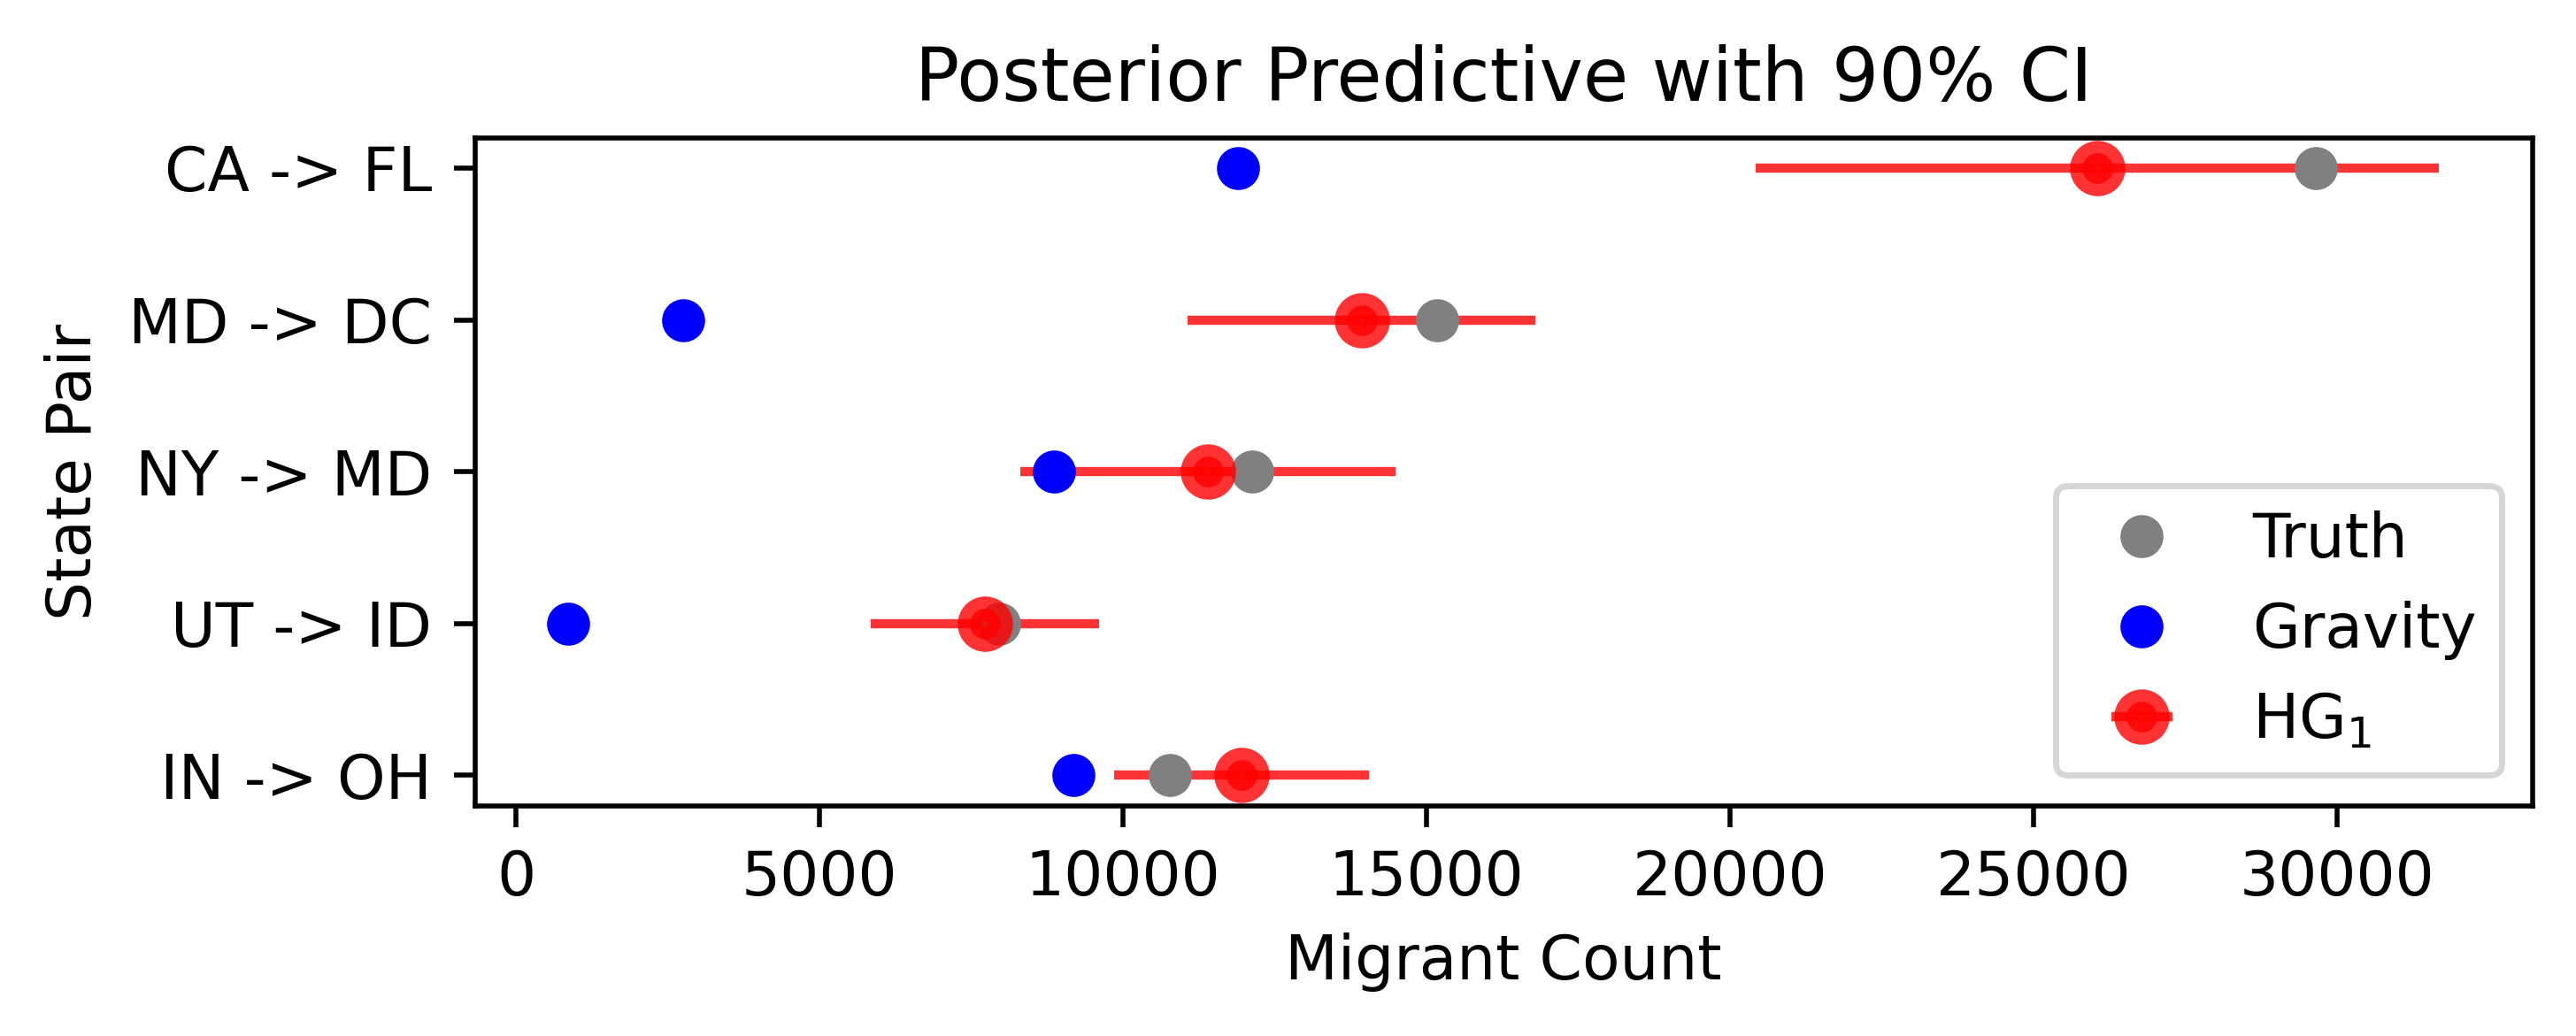

In [107]:
# states_sampled = ['California - Florida', 
#                     'California - Texas', 
#                     # 'New York - Arizona', 
#                     # 'New York - Florida', 
#                     'New York - New Jersey',
#                     ''
#                     # 'Louisiana - Texas',
#                     # 'Florida - Texas',
#                     ]

# num_pairs_sampled = len(states_sampled)
num_pairs_sampled = 5

pair_idx = np.random.choice(pair_code, size=num_pairs_sampled, replace=False)
# pair_idx = pair_le.transform(states_sampled)

samples_predictive = np.exp( Predictive(model, posteriors_model, return_sites=["logM_ijt"])
                            (prng_seed, pair_code, X_test, hyperparameters)["logM_ijt"] )

samples_predictive = np.array([samples_predictive[:,pair_code == pair_idx[i]].mean(axis=1) for i in range(num_pairs_sampled)]).T
# truth = df_test_filtered.groupby('State_pair').M_ij_mean.mean().loc[states_sampled].values
truth = np.array([df_test_filtered.M_ij.values[pair_code == pair_idx[i]].mean() for i in range(n_subsamples)])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, num_pairs_sampled//2), dpi=500)
pred_mean = jnp.mean(samples_predictive, axis=0)
pred_hpdi = hpdi(samples_predictive, 0.9)
residuals = truth - samples_predictive
residuals_mean = jnp.mean(residuals, axis=0)
residuals_hpdi = hpdi(residuals, 0.9)
idx = jnp.argsort(residuals_mean)

y = jnp.arange(num_pairs_sampled)

# ax[0].plot(jnp.zeros(50), y, "--")
ax.errorbar(
    pred_mean[idx],
    y,
    xerr=pred_hpdi[1, idx] - pred_mean[idx],
    marker="o",
    ms=5,
    mew=4,
    ls="none",
    alpha=0.8,
    color="red",
    label="HG$_1$"
)
ax.plot(truth[idx], y, marker="o", ls="none", color="gray", label="Truth")

gravity_ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
grav_pred = np.array([np.exp( gravity_ols.predict( sm.add_constant(X_test) ) )[pair_code == pair_idx[i]].mean() for i in range(num_pairs_sampled)])
ax.plot(grav_pred[idx], y, marker="o", ls="none", color="blue", label="Gravity")
ax.set(
    xlabel="Migrant Count",
    ylabel="State Pair",
    title="Posterior Predictive with 90% CI",
)
ax.set_yticks(y)
state_pair_names = np.array([df_test_filtered.State_pair.values[pair_code == pair_idx[i]][0] for i in range(num_pairs_sampled)])
# thanks to rogerallen/us_state_abbrev.py on GitHub
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC"
}
for k in range(num_pairs_sampled):
    tmp = state_pair_names[k].split(' - ')
    tmp[0] = us_state_to_abbrev[tmp[0]]
    tmp[1] = us_state_to_abbrev[tmp[1]]
    state_pair_names[k] = tmp[0] + ' -> ' + tmp[1]

ax.set_yticklabels(state_pair_names[idx], fontsize=10)
ax.legend();

# # Plot residuals
# err = residuals_hpdi[1] - residuals_mean

# ax[1].plot(jnp.zeros(num_pairs_sampled), y, "--")
# ax[1].errorbar(
#     residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
# )

# ax[1].set(xlabel="Residuals for HG$_1$", title="Residuals with 90% CI")
# ax[1].set_yticks(y)
# ax[1].set_yticklabels(state_pair_names[idx], fontsize=10);

### Varying intercept & coefficients

In [13]:
hg_fully_partial_results = run_experiment(hg_fully_partial, path_count=1, vi=True)

print_results(hg_fully_partial_results, path_count=1)
save_results(hg_fully_partial_results)

Path 1/1 delivers MAE 1080.785
----------------------------------------------
mae_model: 1080.785 +/- nan
r_squared_model: 0.826 +/- nan
cpc_model: 0.826 +/- nan
cpcd_model: 0.968 +/- nan
----------------------------------------------
Percent of warm-up transitions that are divergent: 1.6%


## Radiation

### Varying intercept

In [14]:
hr_intercept_partial_results = run_experiment(hr_intercept_partial, path_count=1, vi=True)

print_results(hr_intercept_partial_results, path_count=1)
save_results(hr_intercept_partial_results)

Path 1/1 delivers MAE 1079.370
----------------------------------------------
mae_model: 1079.370 +/- nan
r_squared_model: 0.825 +/- nan
cpc_model: 0.826 +/- nan
cpcd_model: 0.963 +/- nan
----------------------------------------------
Percent of warm-up transitions that are divergent: 2.0%


### Varying intercept & coefficients

In [15]:
hr_fully_partial_results = run_experiment(hr_fully_partial, path_count=1, vi=True)

print_results(hr_fully_partial_results, path_count=1)
save_results(hr_fully_partial_results)

Path 1/1 delivers MAE 1081.226
----------------------------------------------
mae_model: 1081.226 +/- nan
r_squared_model: 0.825 +/- nan
cpc_model: 0.826 +/- nan
cpcd_model: 0.964 +/- nan
----------------------------------------------
Percent of warm-up transitions that are divergent: 1.6%


## Experiment

In [16]:
hg_experiment_results = run_experiment(hg_experiment, path_count=5)

print_results(hg_experiment_results)
save_results(hg_experiment_results)

Path 1/5 delivers MAE 1559.861
Path 2/5 delivers MAE 1560.340


## Effective Number of Parameters

In [69]:
with open('../results/hg_intercept_partial_results.pkl', 'rb') as f:
    hg_intercept_partial_results = pickle.load(f)

df_train_filtered = df_train.query("path_ind == 0 & M_ij_mean != 0")
X_train = df_train_filtered.set_index('State_pair')[['P_i','P_j','D_ij']]
pair_le = LabelEncoder().fit(X_train.index)
pair_code = pair_le.transform(X_train.index)

X_train = np.log(X_train.astype('float').values)
y_train = np.log(df_train_filtered.M_ij_mean.astype('float').values)

Β_param = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
α_param = y_train.mean() - Β_param @ X_train.mean(axis=0)
ε = y_train - α_param - Β_param @ X_train.T
σ_param = np.sqrt(ε @ ε / ( X_train.shape[0] - X_train.shape[1] - 1 ))
cov_Β = σ_param * np.linalg.inv(sm.add_constant(X_train).T @ sm.add_constant(X_train))
hyperparameters = {'Β_param': np.concatenate([[α_param],Β_param]),
                'σ_param': σ_param,
                'cov_Β': cov_Β}

guide = AutoDiagonalNormal(hg_intercept_partial, init_loc_fn=numpyro.infer.init_to_feasible)
svi = SVI(hg_intercept_partial, guide, Adam(learning_rate), Trace_ELBO())
svi_result = svi.run(prng_seed, vi_iters, pair_code, X_train, hyperparameters, y_train, progress_bar=False)
neutra = NeuTraReparam(guide, svi_result.params)
model = neutra.reparam(hg_intercept_partial)


predictive = Predictive(model, hg_intercept_partial_results['posteriors_model'][0])
posterior_predictive_samples = predictive(prng_seed, pool_code=pair_code, logX_ijt=X_train, hyperparameters=hyperparameters, logM_ijt=y_train)['logM_ijt']

# ll = log_likelihood(model, hg_intercept_partial_results['posteriors_model'][0], pool_code=pair_code, logX_ijt=X_train, hyperparameters=hyperparameters, logM_ijt=y_train, batch_ndims=1)

In [79]:
posterior_predictive_samples

Array([[5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ],
       [5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ],
       [5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ],
       ...,
       [5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ],
       [5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ],
       [5.56068163, 7.46737107, 6.45519856, ..., 5.5683445 , 3.49650756,
        3.8501476 ]], dtype=float64)

In [97]:
import jax.numpy as jnp
from scipy.stats import norm  # or the relevant distribution

# Assuming the observed data is in a variable named `observed_data`
Dθ = []
# Dθbar = []
for i in range(posterior_predictive_samples.shape[1]):
    # Compute the likelihood of the observed data given each set of predictive samples
    likelihoods = norm.pdf(y_train[i], 
                           loc=posterior_predictive_samples[:,i], 
                           scale=hg_intercept_partial_results['posteriors_model'][0]['σ'][:,pair_code][:,i])
    
    # Compute the log of the average likelihood over all samples
    # Dθ += [jnp.log(likelihoods)]
    Dθ += [-2*jnp.log(likelihoods)]

Dθ = np.array(Dθ)

In [100]:
Dθ.var()

0.010435084654063844

In [67]:
hg_fully_partial_results['posteriors_model'][0]['σ'].shape

(1000, 2550)

In [38]:
# HG1
(-2*ll).var(axis=1).mean()/2

Array(5.17409128, dtype=float64)

In [40]:
# HG2
(-2*ll).var(axis=1).mean()/2

Array(5.17409128, dtype=float64)

### Radiation

In [45]:
with open('../results/hr_fully_partial_results.pkl', 'rb') as f:
    hr_fully_partial_results = pickle.load(f)

df_train_filtered = df_train.query("path_ind == 0 & M_ij_mean != 0")
X_train = df_train_filtered.set_index('State_pair')[['P_i','P_j','SP_ij']]
X_train['P_i + SP_ij'] = X_train.P_i + X_train.SP_ij
X_train['P_i + P_j + SP_ij'] = X_train.P_i + X_train.P_j + X_train.SP_ij
pair_le = LabelEncoder().fit(X_train.index)
pair_code = pair_le.transform(X_train.index)
X_train.drop('SP_ij', axis=1, inplace=True)

X_train = np.log(X_train.astype('float').values)
y_train = np.log(df_train_filtered.M_ij_mean.astype('float').values)

Β_param = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
α_param = y_train.mean() - Β_param @ X_train.mean(axis=0)
ε = y_train - α_param - Β_param @ X_train.T
σ_param = np.sqrt(ε @ ε / ( X_train.shape[0] - X_train.shape[1] - 1 ))
cov_Β = σ_param * np.linalg.inv(sm.add_constant(X_train).T @ sm.add_constant(X_train))
hyperparameters = {'Β_param': np.concatenate([[α_param],Β_param]),
                'σ_param': σ_param,
                'cov_Β': cov_Β}

guide = AutoDiagonalNormal(hr_fully_partial, init_loc_fn=numpyro.infer.init_to_feasible)
svi = SVI(hr_fully_partial, guide, Adam(learning_rate), Trace_ELBO())
svi_result = svi.run(prng_seed, vi_iters, pair_code, X_train, hyperparameters, y_train, progress_bar=False)
neutra = NeuTraReparam(guide, svi_result.params)
model = neutra.reparam(hr_fully_partial)

predictive = Predictive(model, hr_fully_partial_results['posteriors_model'][0])
ll = predictive(prng_seed, pool_code=pair_code, logX_ijt=X_train, hyperparameters=hyperparameters, logM_ijt=y_train)['logM_ijt']

# ll = log_likelihood(model, hg_intercept_partial_results['posteriors_model'][0], pool_code=pair_code, logX_ijt=X_train, hyperparameters=hyperparameters, logM_ijt=y_train, batch_ndims=1)

In [43]:
# HR1
(-2*ll).var(axis=1).mean()/2

Array(5.17409128, dtype=float64)

In [51]:
# HR2
(-2*ll).var(axis=1).mean()/2

Array(5.17409128, dtype=float64)

In [61]:
list(hr_fully_partial_results['posteriors_model'][0].keys())

['α',
 'α_decentered',
 'β_1',
 'β_1_decentered',
 'β_2',
 'β_2_decentered',
 'β_3',
 'β_3_decentered',
 'β_4',
 'β_4_decentered',
 'μ_α',
 'μ_β_1',
 'μ_β_2',
 'μ_β_3',
 'μ_β_4',
 'μ_σ',
 'σ',
 'σ_α',
 'σ_β_1',
 'σ_β_2',
 'σ_β_3',
 'σ_β_4']

In [63]:
from numpyro import handlers

model = handlers.substitute(handlers.seed(model, prng_seed), hr_fully_partial_results['posteriors_model'][0])
model_trace = handlers.trace(model).get_trace(pool_code=pair_code, logX_ijt=X_train, hyperparameters=hyperparameters, logM_ijt=y_train)
obs_node = model_trace['obs']
print(obs_node['fn'].log_prob(obs_node['value']))

KeyError: 'σ_α'

# Scraps

In [ ]:
cpc_hg_intercept_partial , cpcd_hg_intercept_partial, mae_hg_intercept_partial , r_squared_hg_intercept_partial = np.empty(path_count), np.empty(path_count), np.empty(path_count), np.empty(path_count)
posteriors_hg = []
for path in df.path_ind.unique()[:path_count]:

    X_train = df_train.query("path_ind == @path").set_index('State_pair')[['P_i','P_j','D_ij']]
    pair_code = LabelEncoder().fit_transform(X_train.index)
    X_train = np.log(1 + X_train.astype('float').values)

    y_train = np.log(1 + df_train.query("path_ind == @path").M_ij.astype('float').values)

    Β_param = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    α_param = y_train.mean() - Β_param @ X_train.mean(axis=0)
    ε = y_train - α_param - Β_param @ X_train.T
    σ_param = np.sqrt(ε @ ε / ( X_train.shape[0] - X_train.shape[1] - 1 ))
    cov_Β = σ_param * np.linalg.inv(sm.add_constant(X_train).T @ sm.add_constant(X_train))
    hyperparameters = {'Β_param': np.concatenate([[α_param],Β_param]),
                    'σ_param': σ_param,
                    'cov_Β': cov_Β}
    #                 'df': X_train.shape[0] - X_train.shape[1] - 1}

    reparam_config = {
        "α": LocScaleReparam(0),
        # "β_1": LocScaleReparam(0),
        # "β_2": LocScaleReparam(0),
    }

    reparam_model = reparam(hg_intercept_partial, config=reparam_config)

    guide = AutoDiagonalNormal(reparam_model, init_loc_fn=numpyro.infer.init_to_feasible)
    svi = SVI(reparam_model, guide, Adam(learning_rate), Trace_ELBO())
    svi_result = svi.run(prng_seed, vi_iters, pair_code, X_train, hyperparameters, y_train, progress_bar=True)
    neutra = NeuTraReparam(guide, svi_result.params)
    reparam_model = neutra.reparam(reparam_model)

    nuts_kernel = NUTS(reparam_model, init_strategy=numpyro.infer.init_to_feasible)

    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, progress_bar=True)
    mcmc.warmup(prng_seed, pair_code, X_train, hyperparameters, y_train, collect_warmup=True, extra_fields=["potential_energy"])
    poten = mcmc.get_extra_fields()["potential_energy"]

    print("sampling posteriors for model of path {}/{}".format(path + 1, path_count))
    mcmc.run(prng_seed, pair_code, X_train, hyperparameters, y_train, extra_fields=["potential_energy"])

    posteriors_hg += [neutra.transform_sample(mcmc.get_samples(group_by_chain=True)['auto_shared_latent'])]

    X_test = df_test.query("path_ind == @path").set_index('State_pair')[['P_i','P_j','D_ij']]
    pair_code = LabelEncoder().fit_transform(X_test.index)
    X_test = np.log(1 + X_test.astype('float').values)
    y_test = df_test.query("path_ind == @path").M_ij

    predictive = Predictive(reparam_model, posteriors_hg[-1], return_sites=["flow"])
    samples_predictive = predictive(prng_seed, pair_code, X_test, hyperparameters)

    pred = np.exp( samples_predictive["flow"].mean(axis=0) ) - 1

    cpc_hg[path] = cpc(y_test, pred)
    cpcd_hg[path] = cpcd(y_test, pred, df_test.query("path_ind == @path").D_ij)
    mae_hg[path] = mae(y_test, pred )
    r_squared_hg[path] = r_squared(y_test, pred)
    print(mae_hg[path])

print("----------------------------------------------")
print("MAE: {}, +/- {}".format(mae_hg.mean(), norm.ppf(.975) * mae_hg.std(ddof=1) / np.sqrt(path_count) ) )
print("R-squared: {}, +/- {}".format(r_squared_hg.mean(), norm.ppf(.975) * r_squared_hg.std(ddof=1) / np.sqrt(path_count) ) )
print("CPC: {}, +/- {}".format(cpc_hg.mean(), norm.ppf(.975) * cpc_hg.std(ddof=1) / np.sqrt(path_count) ) )
print("CPCD: {}, +/- {}".format(cpcd_hg.mean(), norm.ppf(.975) * cpcd_hg.std(ddof=1) / np.sqrt(path_count) ) )

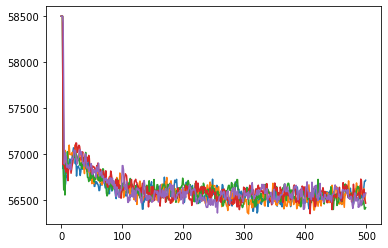

In [22]:
for x in range(num_chains):
    plt.plot(extra_fields['potential_energy'][x])
plt.show()

In [33]:
import arviz as az

data = az.from_numpyro(mcmc, num_chains=num_chains)
az.plot_trace(data, compact=True, figsize=(15, 45));

: 

In [ ]:
import pystan

STAN_MODEL = """
data {
  int<lower=0> N;               // Total number of data points
  int<lower=1, upper=2550> G;   // Number of groups
  int<lower=1, upper=G> group[N];  // Group indicator for each data point
  matrix[N, 3] X;               // Predictor matrix
  vector[N] y;                  // Outcome vector
}

parameters {
  matrix[3, G] beta;            // Coefficients for predictors for each group
  vector[G] alpha;              // Intercept for each group
  real<lower=0> sigma;          // Residual standard deviation
  
  // Hyperparameters for group-level distributions
  vector[3] mu_beta;            // Mean of the beta coefficients across groups
  vector<lower=0>[3] sigma_beta;  // Standard deviation of the beta coefficients across groups
  real mu_alpha;                // Mean of the intercepts across groups
  real<lower=0> sigma_alpha;    // Standard deviation of the intercepts across groups
}

model {
  // Priors
  mu_beta ~ normal(0, 5);
  sigma_beta ~ cauchy(0, 2.5);
  mu_alpha ~ normal(0, 5);
  sigma_alpha ~ cauchy(0, 2.5);
  
  for (j in 1:3) {
    beta[j] ~ normal(mu_beta[j], sigma_beta[j]);
  }
  alpha ~ normal(mu_alpha, sigma_alpha);
  sigma ~ cauchy(0, 2.5);

  // Likelihood
  for (i in 1:N) {
    y[i] ~ normal(dot_product(X[i], beta[,group[i]]) + alpha[group[i]], sigma);
  }
}
"""

X_train = df_train.query("path_ind == 0")[['State_pair','P_i','P_j','D_ij']]
pair_code = LabelEncoder().fit_transform(X_train["State_pair"])
X_train.drop('State_pair', axis=1, inplace=True)
X_train = np.log(1 + X_train.astype('float').values)

y_train = np.log(1 + df_train.query("path_ind == 0").M_ij.values)

data = {
    "N": len(X_train),
    "G": 2550,
    "group": pair_code + 1,
    "X": X_train,
    "y": y_train
}
sm = pystan.StanModel(model_code=STAN_MODEL)
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)

In [5]:
posteriors_hg_param = np.concatenate([posteriors_hg[x]['β_2'] for x in range(1)]).reshape(-1,2550)
posteriors_hg_common = np.concatenate([posteriors_hg[x]['μ_Β'] for x in range(1)])

posteriors_hg_param = {df.State_pair.unique()[i] : posteriors_hg_param[:,i] for i in range(len(df.State_pair.unique())) }

effect_sort = sorted(posteriors_hg_param.items(), key=lambda x : hpdi(x[1], 0.95).mean() )

small_3 = effect_sort[:3]
large_3 = effect_sort[-3:]

np.concatenate([[small_3[x][0] for x in range(3)], [large_3[x][0] for x in range(3)]])

array(['Maine - North Dakota', 'Vermont - North Dakota',
       'South Dakota - Connecticut', 'New York - Texas',
       'Virginia - California', 'New York - California'], dtype='<U26')

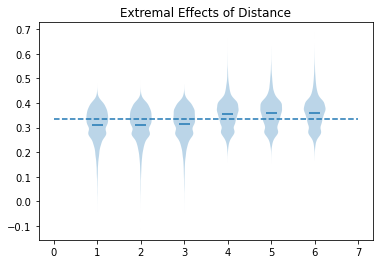

In [6]:
plt.violinplot(np.concatenate([[small_3[x][1] for x in range(3)], [large_3[x][1] for x in range(3)]]).T, showmeans=True, showextrema=False)
plt.hlines(posteriors_hg_common.mean(axis=0).mean(axis=0)[2], xmin=0, xmax=7, linestyles='dashed')
# plt.xticks(np.arange(1,7), ['AR->FL', 'NE->OR', 'CA->FL', 'MO->WA', 'WA->KS', 'NE->KY'], rotation=45)
plt.title('Extremal Effects of Distance')
plt.show()

In [ ]:
with open('../results/posteriors_hg.pkl', 'wb') as f:
    pickle.dump(posteriors_hg, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
count = np.zeros(4)
for i in range(2550):
    tmp = np.where(pair_code == i)[0]
    b = np.linalg.inv(X_train[tmp].T @ X_train[tmp]) @ X_train[tmp].T @ y_train[tmp]
    a = y_train[tmp].mean() - b @ X_train[tmp].mean(axis=0)
    count += np.concatenate([[a],b]) > 0
count / 2550

array([0.48745098, 0.49803922, 0.47921569, 0.53921569])

### Radiation

In [ ]:
def simple_hr(pool_code, factors, outcome):
    # coeff_location = numpyro.sample("coeff_location", dist.Normal(0, 10*jnp.ones(5)))
    coeff_scale = numpyro.sample("coeff_scale", dist.HalfNormal(10*jnp.ones(5)))
    sigma_scale = numpyro.sample("sigma_scale", dist.HalfNormal(10))
    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        coeff0 = numpyro.sample("coeff0", dist.HalfNormal(coeff_scale[0]))
        coeff1 = numpyro.sample("coeff1", dist.HalfNormal(coeff_scale[1]))
        coeff2 = numpyro.sample("coeff2", dist.HalfNormal(coeff_scale[2]))
        coeff3 = -numpyro.sample("coeff3", dist.HalfNormal(coeff_scale[3]))
        coeff4 = -numpyro.sample("coeff4", dist.HalfNormal(coeff_scale[4]))
        sigma = numpyro.sample("sigma", dist.HalfNormal(sigma_scale))
    outcome_est = coeff0[pool_code] + coeff1[pool_code] * factors[:,0] + coeff2[pool_code] * factors[:,1] + coeff3[pool_code] * factors[:,2] + coeff4[pool_code] * factors[:,3]
    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("flow", dist.Normal(outcome_est, sigma[pool_code]), obs=outcome)

In [3]:
def simple_hr(pool_code, factors, outcome):
    σ_Β = numpyro.sample("σ_Β", dist.HalfNormal(np.ones(5)))
    μ_Β = numpyro.sample("μ_Β", dist.Normal(np.zeros(5),1))
    μ_σ = numpyro.sample("μ_σ", dist.HalfNormal(1))
    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        β_0 = numpyro.sample("β_0", dist.Normal(μ_Β[0], σ_Β[0]))
        β_1 = numpyro.sample("β_1", dist.Normal(μ_Β[1], σ_Β[1]))
        β_2 = numpyro.sample("β_2", dist.Normal(μ_Β[2], σ_Β[2]))
        β_3 = numpyro.sample("β_3", dist.Normal(μ_Β[3], σ_Β[3]))
        β_4 = numpyro.sample("β_4", dist.Normal(μ_Β[4], σ_Β[4]))
        σ = numpyro.sample("σ", dist.HalfNormal(np.sqrt(np.pi/2) *  μ_σ ))
    outcome_est = β_0[pool_code] + β_1[pool_code] * factors[:,0] + β_2[pool_code] * factors[:,1] + β_3[pool_code] * factors[:,2] + β_4[pool_code] * factors[:,3]
    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("flow", dist.Normal(outcome_est, σ[pool_code]), obs=outcome)

In [4]:
cpc_hr , cpcd_hr, mae_hr , r_squared_hr = np.empty(path_count), np.empty(path_count), np.empty(path_count), np.empty(path_count)
posteriors_hr = []
for path in df.path_ind.unique()[:path_count]:

    X_train = df_train.query("path_ind == @path")[['State_pair','P_i','P_j','SP_ij']]
    X_train['P_i + SP_ij'] = X_train.P_i + X_train.SP_ij
    X_train['P_i + P_j + SP_ij'] = X_train.P_i + X_train.P_j + X_train.SP_ij
    pair_code = LabelEncoder().fit_transform(X_train["State_pair"])
    X_train.drop(['State_pair','SP_ij'], axis=1, inplace=True)
    X_train = np.log(1 + X_train.astype('float').values)

    y_train = np.log(1 + df_train.query("path_ind == @path").M_ij.values)

    # hyperparameters = jnp.empty(5)
    # hyperparameters = hyperparameters.at[1:].set(jnp.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)
    # hyperparameters = hyperparameters.at[0].set(y_train.mean() - hyperparameters[1:] @ X_train.mean(axis=0))

    guide = AutoDiagonalNormal(simple_hr)
    svi = SVI(simple_hr, guide, Adam(1e-2), Trace_ELBO())
    svi_result = svi.run(random.PRNGKey(465), 30000, pair_code, X_train, y_train, progress_bar=True)
    neutra = NeuTraReparam(guide, svi_result.params)

    reparam_simple_hr = neutra.reparam(simple_hr)
    nuts_kernel = HMC(reparam_simple_hr)
    num_warmup = 500
    num_samples = 2000
    num_chains = 1
    thinning = 1
    
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, thinning=thinning, progress_bar=True)
    mcmc.warmup(random.PRNGKey(235), pair_code, X_train, y_train)
    print("sampling posteriors for model of path {}/{}".format(path + 1, path_count))
    mcmc.run(random.PRNGKey(45), pair_code, X_train, y_train)

    posteriors_hr += [neutra.transform_sample(mcmc.get_samples(group_by_chain=True)['auto_shared_latent'])]

    for name, value in posteriors_hr[-1].items():
        rhat = split_gelman_rubin(value).max()
        print("{} parameter has max R hat {}".format(name, rhat))
    
    
    # make sure structure is intact
    print("{}%% of intercepts are structurally intact".format(100 * np.mean( hpdi(posteriors_hr[-1]['β_0'],0.9)[0] > 0 )))
    print("{}%% of origin utility coefficients are structurally intact".format(100 * np.mean( hpdi(posteriors_hr[-1]['β_1'],0.9)[0] > 0 )))
    print("{}%% of destination utility coefficients are structurally intact".format(100 * np.mean( hpdi(posteriors_hr[-1]['β_2'],0.9)[0] > 0 )))
    print("{}%% of 1st intervening opportunity coefficients are structurally intact".format(100 * np.mean( hpdi(posteriors_hr[-1]['β_3'],0.9)[1] < 0 )))
    print("{}%% of 2nd intervening opportunity coefficients are structurally intact".format(100 * np.mean( hpdi(posteriors_hr[-1]['β_4'],0.9)[1] < 0 )))
    

    # X_test = df_test.query("path_ind == @path")[['State_pair','P_i','P_j','SP_ij']]
    # X_test['P_i + SP_ij'] = X_test.P_i + X_test.SP_ij
    # X_test['P_i + P_j + SP_ij'] = X_test.P_i + X_test.P_j + X_test.SP_ij
    # pair_code = LabelEncoder().fit_transform(X_test["State_pair"])
    # X_test.drop(['State_pair','SP_ij'], axis=1, inplace=True)
    # X_test = np.log(1 + X_test.values)
    # y_test = df_test.query("path_ind == @path").M_ij

    # predictive = Predictive(reparam_simple_hr, posteriors_hr[-1], return_sites=["flow"])
    # samples_predictive = predictive(random.PRNGKey(987), pair_code, X_test, None)

    # pred = np.exp( samples_predictive["flow"].mean(axis=0) ) - 1

    # cpc_hr[path] = cpc(y_test, pred)
    # cpcd_hr[path] = cpcd(y_test, pred, df_test.query("path_ind == @path").D_ij)
    # mae_hr[path] = mae(y_test, pred)
    # r_squared_hr[path] = r_squared(y_test, pred)
    break

# print("----------------------------------------------")
# print("MAE: {}, +/- {}".format(mae_hr.mean(), norm.ppf(.975) * mae_hr.std(ddof=1) / np.sqrt(path_count) ) )
# print("R-squared: {}, +/- {}".format(r_squared_hr.mean(), norm.ppf(.975) * r_squared_hr.std(ddof=1) / np.sqrt(path_count) ) )
# print("CPC: {}, +/- {}".format(cpc_hr.mean(), norm.ppf(.975) * cpc_hr.std(ddof=1) / np.sqrt(path_count) ) )
# print("CPCD: {}, +/- {}".format(cpcd_hr.mean(), norm.ppf(.975) * cpcd_hr.std(ddof=1) / np.sqrt(path_count) ) )

100%|██████████| 30000/30000 [03:04<00:00, 162.95it/s, init loss: 148695885.0271, avg. loss [28501-30000]: 55677.7211]


In [ ]:
with open('../results/posteriors_hr.pkl', 'wb') as f:
    pickle.dump(posteriors_hr, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
count = np.zeros(5)
for i in range(2550):
    tmp = np.where(pair_code == i)[0]
    b = np.linalg.inv(X_train[tmp].T @ X_train[tmp]) @ X_train[tmp].T @ y_train[tmp]
    a = y_train[tmp].mean() - b @ X_train[tmp].mean(axis=0)
    count += np.concatenate([[a],b]) > 0
count / 2550

array([0.50627451, 0.51372549, 0.46235294, 0.47176471, 0.5254902 ])

### Generalized Gravity

In [ ]:
def hgg(pool_code, d_ij, y, scaled_factors_origin, scaled_factors_destination):
    
    λ = numpyro.sample("λ", dist.HalfNormal(10))
    w = numpyro.sample("w", dist.Laplace(0, λ * jnp.ones(scaled_factors_origin.shape[1])))
    U_i = jnp.dot(w , scaled_factors_origin.T)
    U_j = jnp.dot(w , scaled_factors_destination.T)

    X = jnp.array([jnp.log(1 + U_i), jnp.log(1 + U_j),  jnp.log(1 + d_ij)]).T

    # hyperparameters = jnp.ones(4)
    # if y is not None:
    #     hyperparameters = hyperparameters.at[1:].set(jnp.linalg.inv(X.T @ X) @ X.T @ y)
    #     hyperparameters = hyperparameters.at[0].set(y.mean() - hyperparameters[1:] @ X.mean(axis=0))

    Β_σ = numpyro.sample("Β_σ", dist.HalfNormal(10*jnp.ones(4)))
    # coeff_location = numpyro.sample("coeff_location", dist.LogNormal(1, jnp.ones(4)))
    σ_σ = numpyro.sample("σ_σ", dist.HalfNormal(10))
    
    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        β_0 = -numpyro.sample("β_0", dist.HalfNormal(Β_σ[0]))
        β_1 = numpyro.sample("β_1", dist.HalfNormal(Β_σ[1]))
        β_2 = numpyro.sample("β_2", dist.HalfNormal(Β_σ[2]))
        β_3 = -numpyro.sample("β_3", dist.HalfNormal(Β_σ[3]))
        σ = numpyro.sample("σ", dist.HalfNormal(σ_σ))

    logM_ij = β_0[pool_code] + β_1[pool_code] * X[:,0] + β_2[pool_code] * X[:,1] + β_3[pool_code] * X[:,2]

    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("flow", dist.Normal(logM_ij, σ[pool_code]), obs=y)

In [ ]:
def hgg(pool_code, d_ij, y, scaled_factors_origin, scaled_factors_destination):
    
    w = numpyro.sample("w", dist.Normal(0,jnp.ones(scaled_factors_origin.shape[1])))
    U_i = jnp.dot(w , scaled_factors_origin.T)
    U_j = jnp.dot(w , scaled_factors_destination.T)

    X = jnp.array([jnp.log(1 + U_i), jnp.log(1 + U_j),  jnp.log(1 + d_ij)]).T

    # hyperparameters = jnp.ones(4)
    # if y is not None:
    #     hyperparameters = hyperparameters.at[1:].set(jnp.linalg.inv(X.T @ X) @ X.T @ y)
    #     hyperparameters = hyperparameters.at[0].set(y.mean() - hyperparameters[1:] @ X.mean(axis=0))

    coeff_scale = numpyro.sample("coeff_scale", dist.HalfNormal(100 * jnp.ones(4)))
    # coeff_location = numpyro.sample("coeff_location", dist.LogNormal(1, jnp.ones(4)))
    sigma_scale = numpyro.sample("sigma_scale", dist.HalfNormal(100))
    
    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        coeff0 = -numpyro.sample("coeff0", dist.HalfNormal(coeff_scale[0]))
        coeff1 = numpyro.sample("coeff1", dist.HalfNormal(coeff_scale[1]))
        coeff2 = numpyro.sample("coeff2", dist.HalfNormal(coeff_scale[2]))
        coeff3 = -numpyro.sample("coeff3", dist.HalfNormal(coeff_scale[3]))
        sigma = numpyro.sample("sigma", dist.HalfNormal(sigma_scale))

    outcome_est = coeff0[pool_code] + coeff1[pool_code] * X[:,0] + coeff2[pool_code] * X[:,1] + coeff3[pool_code] * X[:,2]

    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("flow", dist.Normal(outcome_est, sigma[pool_code]), obs=y)

In [ ]:
cpc_hgg , cpcd_hgg , mae_hgg, r_squared_hgg = np.empty(path_count), np.empty(path_count), np.empty(path_count), np.empty(path_count)
posteriors_hgg = []
for path in df.path_ind.unique()[:path_count]:

    X_train = df_train.query("path_ind == @path")
    pair_code = LabelEncoder().fit_transform(X_train["State_pair"])
    y_train = np.log(1 + df_train.query("path_ind == @path").M_ij.values)

    tmp = np.log(1 + X_train.loc[:,'P_i':])
    scaled_factors = 1 / (1 + np.exp(- (tmp - tmp.mean(axis=0)) / tmp.std(ddof=1, axis=0) ))

    features = {'population': ['P_i','P_j'],
            'housing': ['H_i','H_j'],
            'income': ['I_i','I_j'],
            'affordability': ['AF_i','AF_j'],
            'area': ['A_i','A_j'],
            'density': ['rho_i','rho_j'],
            'climate risk': ['ADC_i','ADC_j']
    }

    features_origin = list(np.array(list(features.values()))[:,0])
    features_destination = list(np.array(list(features.values()))[:,1])

    guide = AutoDiagonalNormal(hgg)
    svi = SVI(hgg, guide, Adam(1e-2), Trace_ELBO())
    svi_result = svi.run(random.PRNGKey(465), 15000, pair_code, X_train.D_ij.values, y_train, scaled_factors[features_origin].values, scaled_factors[features_destination].values, progress_bar=True)
    neutra = NeuTraReparam(guide, svi_result.params)

    reparam_hgg = neutra.reparam(hgg)
    nuts_kernel = NUTS(reparam_hgg, target_accept_prob=0.9)
    num_warmup = 3000
    num_samples = 5000
    num_chains = 5
    thinning = 1

    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, thinning=thinning, progress_bar=False)
    mcmc.warmup(random.PRNGKey(235), pair_code, X_train.D_ij.values, y_train, scaled_factors[features_origin].values, scaled_factors[features_destination].values)
    print("sampling posteriors for model of path {}/{}".format(path + 1, path_count))
    mcmc.run(random.PRNGKey(45), pair_code, X_train.D_ij.values, y_train, scaled_factors[features_origin].values, scaled_factors[features_destination].values)

    posteriors_hgg += [neutra.transform_sample(mcmc.get_samples(group_by_chain=True)['auto_shared_latent'])]

    for name, value in posteriors_hgg[-1].items():
        rhat = split_gelman_rubin(value).max()
        print("{} parameter has max R hat {}".format(name, rhat))
        # assert rhat < 1.1, "R hat too large"

    X_test = df_test.query("path_ind == @path")
    pair_code = LabelEncoder().fit_transform(X_test["State_pair"])
    y_test = df_test.query("path_ind == @path").M_ij

    tmp = np.log(1 + X_test.loc[:,'P_i':])
    scaled_factors = 1 / (1 + np.exp(- (tmp - tmp.mean(axis=0)) / tmp.std(ddof=1, axis=0) ))

    predictive = Predictive(reparam_hgg, posteriors_hgg[-1], return_sites=["flow"])
    samples_predictive = predictive(random.PRNGKey(45), pair_code, X_test.D_ij.values, None, scaled_factors[features_origin].values, scaled_factors[features_destination].values)

    pred = np.exp( samples_predictive["flow"].mean(axis=0) ) - 1

    cpc_hgg[path] = cpc(y_test, pred) 
    cpcd_hgg[path] = cpcd(y_test, pred, df_test.query("path_ind == @path").D_ij) 
    mae_hgg[path] = mae(y_test, pred )
    r_squared_hgg[path] = r_squared(y_test, pred)
    break

print("----------------------------------------------")
print("MAE: {}, +/- {}".format(mae_hgg.mean(), norm.ppf(.975) * mae_hgg.std(ddof=1) / np.sqrt(path_count) ) )
print("R-squared: {}, +/- {}".format(r_squared_hgg.mean(), norm.ppf(.975) * r_squared_hgg.std(ddof=1) / np.sqrt(path_count) ) )
print("CPC: {}, +/- {}".format(cpc_hgg.mean(), norm.ppf(.975) * cpc_hgg.std(ddof=1) / np.sqrt(path_count) ) )
print("CPCD: {}, +/- {}".format(cpcd_hgg.mean(), norm.ppf(.975) * cpcd_hgg.std(ddof=1) / np.sqrt(path_count) ) )

100%|██████████| 15000/15000 [00:57<00:00, 258.67it/s, init loss: 54766557.0097, avg. loss [14251-15000]: 56465.3769]


sampling posteriors for model of path 1/5
w parameter has max R hat 1.0427090990433645
Β_σ parameter has max R hat 2.074385702014173
β_0 parameter has max R hat 1.213334797391755
β_1 parameter has max R hat 1.014434212657786
β_2 parameter has max R hat 1.0115771013546584
β_3 parameter has max R hat 1.3026257563148411
σ parameter has max R hat 1.0026172766152637
σ_σ parameter has max R hat 1.0010055833274218
----------------------------------------------
MAE: 235.65779904011396, +/- 461.88079879460105
R-squared: 0.1583558564928956, +/- 0.3103717754670686
CPC: 0.15804387603830505, +/- 0.30976030501219076
CPCD: 0.18939541439655494, +/- 0.37120819105428654


In [ ]:
with open('../results/posteriors_hgg.pkl', 'wb') as f:
    pickle.dump(posteriors_hgg, f, protocol=pickle.HIGHEST_PROTOCOL)

### Generalized Radiation

In [ ]:
def hgr(pool_code, X, y, scaled_factors, local_region_sum, features_origin, features_destination):
    
    w = numpyro.sample("w", dist.Normal(0, 10*jnp.ones(len(features_origin))))
    U_i = jnp.dot(w , scaled_factors[features_origin].values.T)
    U_j = jnp.dot(w , scaled_factors[features_destination].values.T)
    SU_ij = jnp.dot(w, local_region_sum.T)
    coeff_scale = numpyro.sample("coeff_scale", dist.HalfNormal(100*jnp.ones(6)))
    # coeff_location = numpyro.sample("beta_location", dist.Normal(0, 10*jnp.ones(6)))
    sigma_scale = numpyro.sample("sigma_scale", dist.HalfNormal(100))
    
    n_pairs = len(np.unique(pool_code))
    with numpyro.plate("levels", n_pairs):
        coeff0 = -1 * numpyro.sample("coeff0", dist.HalfNormal(coeff_scale[0]))
        coeff1 = numpyro.sample("coeff1", dist.HalfNormal(coeff_scale[1]))
        coeff2 = numpyro.sample("coeff2", dist.HalfNormal(coeff_scale[2]))
        coeff3 = numpyro.sample("coeff3", dist.HalfNormal(coeff_scale[3]))
        coeff4 = -1 * numpyro.sample("coeff4", dist.HalfNormal(coeff_scale[4]))
        coeff5 = -1 * numpyro.sample("coeff5", dist.HalfNormal(coeff_scale[5]))
        sigma = numpyro.sample("sigma", dist.HalfNormal(sigma_scale))
    
    M_ij = coeff0[pool_code] + coeff1[pool_code] * np.log(1 + X.P_i.values) + coeff2[pool_code] * jnp.log(1 + U_i) + coeff3[pool_code] * jnp.log(1 + U_j) + \
        coeff4[pool_code] * jnp.log(1 + U_i + SU_ij) + coeff5[pool_code] * jnp.log(1 + U_i + U_j + SU_ij)
    
    with numpyro.plate("data", len(pool_code)):
        numpyro.sample("flow", dist.Normal(M_ij, sigma[pool_code]), obs=y)

In [ ]:
features = {'population': ['P_i','P_j'],
        'housing': ['H_i','H_j'],
        'income': ['I_i','I_j'],
        'affordability': ['AF_i','AF_j'],
        'area': ['A_i','A_j'],
        'density': ['rho_i','rho_j'],
        'climate risk': ['ADC_i','ADC_j']
}
features_origin = list(np.array(list(features.values()))[:,0])
features_destination = list(np.array(list(features.values()))[:,1])

cpc_hgr , cpcd_hgr , mae_hgr, r_squared_hgr = np.empty(path_count), np.empty(path_count), np.empty(path_count), np.empty(path_count)
weights_hgr, coeff_hgr = np.empty((path_count,len(features))), np.empty((path_count,2550,6))
posteriors_hgr = []
for path in df.path_ind.unique()[:path_count]:
    X_train = df_train.query("path_ind == @path")
    pair_code = LabelEncoder().fit_transform(X_train["State_pair"])
    y_train = np.log(1 + df_train.query("path_ind == @path").M_ij.values)

    tmp = np.log(1 + X_train.loc[:,'P_i':])
    scaled_factors = pd.concat([X_train[['State_i','State_j']], 
                                1 / (1 + np.exp(- (tmp - tmp.mean(axis=0))\
                                    / tmp.std(ddof=1, axis=0) ))],
                                axis=1)
    
    local_region_sum = np.empty((len(X_train), len(features)))
    for i in range(len(X_train)):
        intervening_states = states[distance[X_train.State_i.iloc[i]] < distance[X_train.State_i.iloc[i]][X_train.State_j.iloc[i]]]\
                            .drop(X_train.State_i.iloc[i])
        if len(intervening_states):
            local_region_sum[i] = np.array([scaled_factors.query("Year == {} & State_i == '{}'"\
                                .format(scaled_factors.index[i], local_state))[features_origin].values[0]
                                    for local_state in intervening_states]
                            ).sum(axis=0)
        else:
            local_region_sum[i] = np.array([0.]*len(features))

    guide = AutoDiagonalNormal(hgr)
    optimizer = numpyro.optim.Adam(step_size=1e-2)
    svi = SVI(hgr, guide, optimizer, Trace_ELBO())
    svi_result = svi.run(random.PRNGKey(0), 20000, pair_code, X_train, y_train, scaled_factors, local_region_sum, features_origin, features_destination)
    neutra = NeuTraReparam(guide, svi_result.params)
    
    reparam_hgr = neutra.reparam(hgr)
    nuts_kernel = NUTS(reparam_hgr)
    num_warmup = 10
    num_samples = 1000
    num_chains = 5
    thinning = 1

    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, thinning=thinning, num_chains=num_chains, progress_bar=False)
    mcmc.warmup(random.PRNGKey(235), pair_code, X_train, y_train, scaled_factors, local_region_sum, features_origin, features_destination)
    print("sampling posteriors for model of path {}/{}".format(path + 1, path_count))
    mcmc.run(random.PRNGKey(45), pair_code, X_train, y_train, scaled_factors, local_region_sum, features_origin, features_destination)

    samples = neutra.transform_sample(mcmc.get_samples(group_by_chain=True)['auto_shared_latent'])

    posteriors_hgr += [samples]

    for name, value in samples.items():
        rhat = split_gelman_rubin(value).max()
        print("{} parameter has max R hat {}".format(name, rhat))

    X_test = df_test.query("path_ind == @path")
    pair_code = LabelEncoder().fit_transform(X_test["State_pair"])
    y_test = df_test.query("path_ind == @path").M_ij

    tmp = np.log(1 + X_test.loc[:,'P_i':])
    scaled_factors = pd.concat([X_test[['State_i','State_j']], 
                                1 / (1 + np.exp(- (tmp - tmp.mean(axis=0))\
                                    / tmp.std(ddof=1, axis=0) ))],
                                axis=1)

    local_region_sum = np.empty((len(X_test), len(features)))
    for i in range(len(X_test)):
        intervening_states = states[distance[X_test.State_i.iloc[i]] < distance[X_test.State_i.iloc[i]][X_test.State_j.iloc[i]]]\
                            .drop(X_test.State_i.iloc[i])
        if len(intervening_states):
            local_region_sum[i] = np.array([scaled_factors.query("Year == {} & State_i == '{}'"\
                                .format(scaled_factors.index[i], local_state))[features_origin].values[0]
                                    for local_state in intervening_states]
                            ).sum(axis=0)
        else:
            local_region_sum[i] = np.array([0.]*len(features))

    predictive = Predictive(reparam_hgr, samples, return_sites=["flow"])
    samples_predictive = predictive(random.PRNGKey(0), pair_code, X_test, None, scaled_factors, local_region_sum, features_origin, features_destination)

    pred = np.exp( samples_predictive["flow"].mean(axis=0) ) - 1

    weights_hgr[path] = samples_predictive["w"].mean(axis=0)
    coeff_hgr[path] = np.array([samples_predictive["coeff0"].mean(axis=0),
                     samples_predictive["coeff1"].mean(axis=0),
                     samples_predictive["coeff2"].mean(axis=0),
                     samples_predictive["coeff3"].mean(axis=0),
                     samples_predictive["coeff4"].mean(axis=0),
                     samples_predictive["coeff5"].mean(axis=0)]).T

    cpc_hgr[path] = cpc(y_test, pred)
    cpcd_hgr[path] = cpcd(y_test, pred, df_test.query("path_ind == @path").D_ij) 
    mae_hgr[path] = mae(y_test, pred )
    r_squared_hgr[path] = r_squared(y_test, pred) 

print("----------------------------------------------")
print("MAE:",           mae_hgr.mean()      , "+\-", norm.ppf(.975) * mae_hgr.std(ddof=1)       / np.sqrt(path_count)  )
print("R-squared:",     r_squared_hgr.mean(), "+\-", norm.ppf(.975) * r_squared_hgr.std(ddof=1) / np.sqrt(path_count)  )
print("CPC:",           cpc_hgr.mean()      , "+\-", norm.ppf(.975) * cpc_hgr.std(ddof=1)       / np.sqrt(path_count)  )
print("CPCD:",          cpcd_hgr.mean()     , "+\-", norm.ppf(.975) * cpcd_hgr.std(ddof=1)      / np.sqrt(path_count)  )

In [ ]:
with open('results/posteriors_hgr.pkl', 'wb') as f:
    pickle.dump(posteriors_hgr, f, protocol=pickle.HIGHEST_PROTOCOL)